# Ajuste y Selección del Mejor Modelo

Para este ejercicio se estarán usando modelos basados en árboles de decisión debido a la robustez frente a distribuciones sesgadas y sus métodos de optimización optimizacion. 

## Importación de librerías

In [1]:
import pandas as pd
import numpy as np

# Librerías para graficar
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos clásicos 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Librerías para estudio de importancia de variables y partición de la base
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score,  confusion_matrix, roc_curve, precision_recall_curve

# Librería para búsquedad automática
from pycaret.classification  import *

# Librería para exportar el modelo construido
import joblib


## Importación Matriz de Datos

In [2]:
# Se importa la base de datos ya preprocesada
file_path=r"..\data\MatrizDatos.csv"
X = pd.read_csv(
    file_path,
    sep=';',
    decimal=','
)

# Se elimina esta varible por no aportar valor predictivo
X=X.drop(columns='DxH')

print(X.info())
X

<class 'pandas.core.frame.DataFrame'>
Index: 16880 entries, 0 to 16879
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       16880 non-null  int64  
 1   B       16880 non-null  float64
 2   C       16880 non-null  float64
 3   D       16880 non-null  int64  
 4   E       16880 non-null  int64  
 5   H       16880 non-null  int64  
 6   M       16880 non-null  int64  
 7   N       16880 non-null  int64  
 8   O       16880 non-null  int64  
 9   P       16880 non-null  int64  
 10  Q       16880 non-null  float64
 11  R       16880 non-null  float64
 12  S       16880 non-null  float64
 13  Monto   16880 non-null  float64
 14  Fraude  16880 non-null  int64  
 15  J_AR    16880 non-null  int64  
 16  J_BR    16880 non-null  int64  
dtypes: float64(6), int64(11)
memory usage: 2.3 MB
None


,A,B,C,D,E,H,M,N,O,P,Q,R,S,Monto,Fraude,J_AR,J_BR
0,0,3.162278,224.180731,0,0,0,1,0,0,1,0.0,0.0,2.692582,6.124541,1,0,0
1,0,3.162278,170.334964,0,0,0,0,0,0,1,0.0,0.0,3.414674,2.860070,1,0,0
2,0,2.645751,9.591663,0,1,0,1,0,0,1,0.0,0.0,9.325771,3.736308,1,0,0
3,1,4.000000,224.207493,0,0,0,1,0,0,1,0.0,0.0,1.584298,9.678326,1,0,0
4,0,2.828427,90.443352,0,0,0,0,0,0,0,0.0,0.0,5.095096,11.636151,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16875,0,1.732051,251.598887,0,1,0,0,0,0,0,0.0,0.0,9.259050,11.496521,1,0,1
16876,0,3.464102,28.722813,0,0,0,0,0,0,1,0.0,0.0,3.535534,5.132251,1,0,1
16877,1,1.732051,284.722672,0,0,0,0,0,0,0,0.0,0.0,4.915282,13.986779,1,0,1
16878,0,3.000000,631.167173,0,0,0,1,0,0,0,0.0,0.0,5.385165,6.080296,1,0,1


## Búsqueda del mejor modelo

Se realiza una búsqueda automática del mejor modelo candidato para después optimizarlo. Para ello se utiliza pycaret.

In [74]:
# Construccion de muestras aleatorias, 80% para entrenamiento y 20% para evaluación
x_train = X.sample(frac=0.80, random_state=123)
x_test = X.drop(x_train.index)

print("Se utilizarán", x_train.shape[0], f"datos para entrenamiento ({int(np.round(x_train.shape[0]/X.shape[0]*100,0))}%)")
print("Se utilizarán", x_test.shape[0], f"datos para evaluación ({int(np.round(x_test.shape[0]/X.shape[0]*100,0))}%)")

Se utilizarán 13504 datos para entrenamiento (80%)
Se utilizarán 3376 datos para evaluación (20%)


In [75]:
# Especificación de parámatros de búsqueda, se establece la semilla 123 para reproducibilidad
model_setup = setup(
    data=x_train, 
    target='Fraude', 
    session_id=123,
    fix_imbalance=True, # Este parámetro ayuda a tratar el desbalance presente en el Fraude
    feature_selection=True,          # Hace selección automática de variables
    feature_selection_method="classic", # Método de selección
    feature_selection_estimator="lightgbm" # Modelo base para evaluar importancia
)

[LightGBM] [Info] Number of positive: 6876, number of negative: 6876
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3428
[LightGBM] [Info] Number of data points in the train set: 13752, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000


,Description,Value
0,Session id,123
1,Target,Fraude
2,Target type,Binary
3,Original data shape,"(13504, 17)"
4,Transformed data shape,"(17804, 4)"
5,Transformed train set shape,"(13752, 4)"
6,Transformed test set shape,"(4052, 4)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


In [ ]:
# Aquí se ajustan los modelos y se obtienen sus resultados para compararlos
best_model = compare_models()

In [77]:
results = pull()
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7770,0.8254,0.5299,0.6156,0.5639,0.4165,0.4225,5.339
lightgbm,Light Gradient Boosting Machine,0.7754,0.8250,0.5435,0.6064,0.5690,0.4188,0.4228,0.571
xgboost,Extreme Gradient Boosting,0.7702,0.8182,0.5567,0.5912,0.5701,0.4143,0.4169,0.416
gbc,Gradient Boosting Classifier,0.7544,0.8183,0.6491,0.5448,0.5911,0.4182,0.4223,0.664
rf,Random Forest Classifier,0.7530,0.8022,0.5746,0.5472,0.5595,0.3883,0.3892,0.934
et,Extra Trees Classifier,0.7411,0.7776,0.5416,0.5280,0.5334,0.3547,0.3556,0.506
dummy,Dummy Classifier,0.7275,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.436
dt,Decision Tree Classifier,0.7168,0.6490,0.5000,0.4831,0.4907,0.2949,0.2954,0.296
ada,Ada Boost Classifier,0.7128,0.8026,0.7345,0.4833,0.5826,0.3779,0.3974,0.515
knn,K Neighbors Classifier,0.6969,0.7519,0.6530,0.4612,0.5401,0.3242,0.3354,1.249


Se eligirá como modelo a optimizar Light Gradient Boosting Machine por sus resultados en AUC, F1 y el tiempo

## Optimización Mejor Modelo

Ya encontrado, empezaremos la obtimización del modelo buscando los mejores parámetros que nos garanticen las mejores proyecciones

In [3]:
# Construcción de data de entrenamiento y test
data = X.drop(columns='Fraude')
y = X['Fraude']

# Partición de la matriz de datos
x_train, x_test, y_train, y_test = train_test_split(
    data, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=123
)

In [79]:
# Modelo base
model = LGBMClassifier(random_state=123)

# Grilla de parámetros a usar
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [5, 7, -1],
    'num_leaves': [15, 31],
    'class_weight':['balanced'],

    # Bloque de parámetros para trabajar overfitting
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0.1, 1]
}

# Especificaciones de validación cruzada y GridSearchCV 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',      
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [ ]:
# Búsqueda a partir de la optimización de parámetros
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LightGBM] [Info] Number of positive: 3228, number of negative: 8588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 11816, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=None, num_leaves=31,
                                      objective=None...
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'colsample_bytree': [0.7, 1.0],
                         'learning_rate': [0.01, 0.05], 'max_depth': [5, 7, -1],
                         'n_estimators': [100, 200], 'num_leaves': [15, 31],
                         'reg_alpha': [0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=2)

In [91]:
print("Mejor combinación de hiperparámetros:")
grid_search.best_params_

Mejor combinación de hiperparámetros:


{'class_weight': 'balanced',
 'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': -1,
 'n_estimators': 200,
 'num_leaves': 31,
 'reg_alpha': 1}

In [92]:
print(f"Mejor F1-Score (CV): {grid_search.best_score_:.4f}")

Mejor F1-Score (CV): 0.6329


In [94]:
# Se guarda el mejor modelo
best_model = grid_search.best_estimator_

### Evaluando el reindimiento del modelo

#### Umbral óptimo

##### **Maximización métrica F1-Score**
Primero obtengamos el umbral de clasificación en el que justo se máximiza nuestra métrica objetivo f1-score. Es como sigue:

In [7]:
best_model = joblib.load(r"C:\Users\EXNOAANIETO\Documents\NOVAVENTA_ANALITICA\tutorials\models\modelo_fraude.joblib")

Umbral óptimo: 0.5653
F1-score máximo: 0.6382


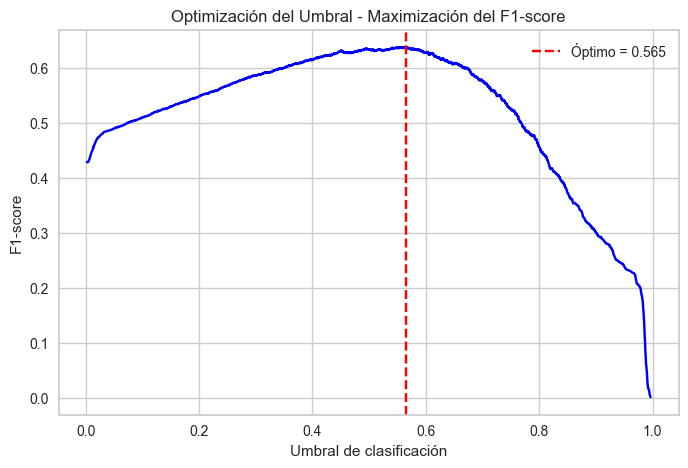

In [8]:
# Se obtienen las probabilidades predichas de cometer fraude
y_prob = best_model.predict_proba(x_test)[:, 1]

# Se calcula la curva de precisión y recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# Se obtienen los valores del f1-score para cada umbral posible
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Se identifica el umbral óptimo
opt_idx = np.argmax(f1_scores)
umbral_optimo = thresholds[opt_idx]
opt_f1 = f1_scores[opt_idx]

print(f"Umbral óptimo: {umbral_optimo:.4f}")
print(f"F1-score máximo: {opt_f1:.4f}")

# Visualización de la optimización del umbral sobre el f1-score
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores[:-1], color='blue')
plt.axvline(umbral_optimo, color='red', linestyle='--', label=f'Óptimo = {umbral_optimo:.3f}')
plt.title('Optimización del Umbral - Maximización del F1-score')
plt.xlabel('Umbral de clasificación')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True)
plt.show()


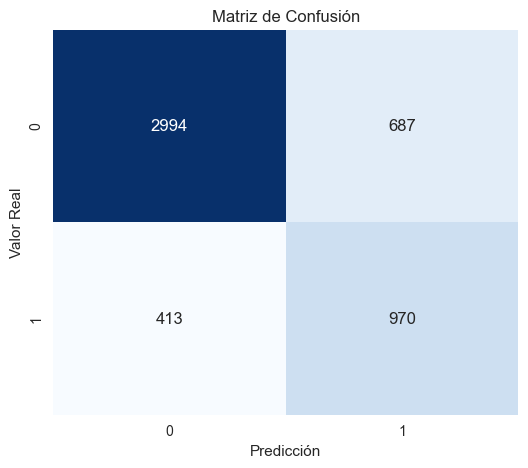


Reporte de métricas por categoría:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      3681
           1       0.59      0.70      0.64      1383

    accuracy                           0.78      5064
   macro avg       0.73      0.76      0.74      5064
weighted avg       0.80      0.78      0.79      5064



In [16]:
# Calcular la matriz de confusión
y_pred = (y_prob >= umbral_optimo).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Graficar
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

print("\nReporte de métricas por categoría:")
print(classification_report(y_test, y_pred))

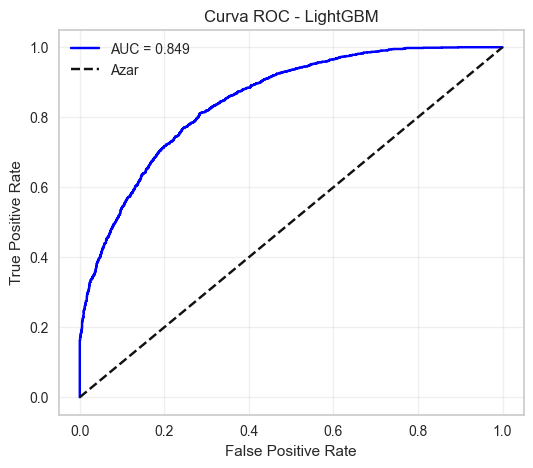

In [117]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='blue')
plt.plot([0,1], [0,1], 'k--', label='Azar')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - LightGBM')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

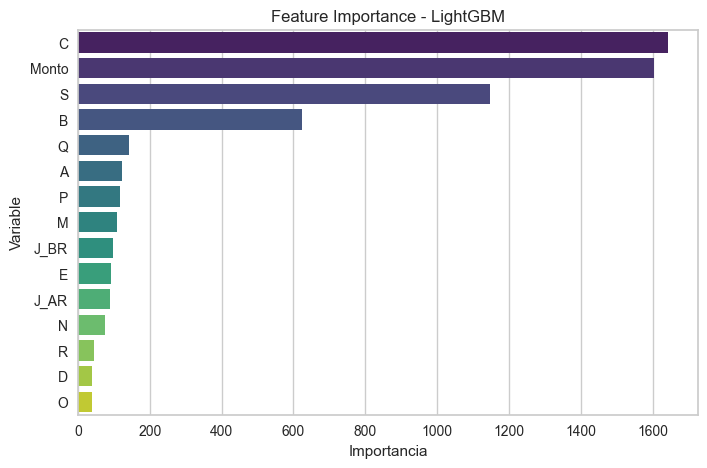

In [ ]:
# Cálculo de la importancia predictiva de cada variable
importances = best_model.feature_importances_
features = x_train.columns

# Base de datos con información de importancia de variables
feat_imp = (
    pd.DataFrame({'Variable': features, 'Importancia': importances})
    .sort_values(by='Importancia', ascending=False)
)

# Gráfico de importancia de variables 
plt.figure(figsize=(8,5))
sns.barplot(data=feat_imp.head(15), x='Importancia', y='Variable', palette='viridis')
plt.title('Feature Importance - LightGBM')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

Con este resultado vemos que el poder predictivo del modelo se concentra principalmente en el top 7 de sus variables, indicando que el modelo aún se puede fortalecer más buscado volverlo más parsimonioso.

En coclusión, un patrón explicado por las variables C, Monto, S, B, Q y A normalmente termina conduciendo a un acierto.

In [26]:
# Se obtienen los montos por cada caso de acierto-error para medición de la rentabilidad del modelo
df_evaluación_montos=pd.DataFrame(
    {
        'Monto':x_test['Monto']**2, # Se eleva al cuadrado porque la variable está transformada por raíz cuadrada
        'Fraude':y_test,
        'Pred_Fraude':y_pred
    }
)

print(df_evaluación_montos.groupby(['Fraude', 'Pred_Fraude']).agg(
    MONTO_TOTAL=('Monto', 'sum')
).round(0))

print("\nMonto total:", (x_test['Monto']**2).sum())

                    MONTO_TOTAL
Fraude Pred_Fraude             
0      0               554856.0
       1                90225.0
1      0                63418.0
       1               120657.0

Monto total: 829156.04


El modelo presenta un desempeño moderado, es capaz de capturar los patrones relacionados al fraude y, en general, por su auc del 85% ayuda a aumentar las posibilidades de acierto en la detección de estos patrones negativos. 

Nos logramos rentabilizar en la medida que seamos precisos en aprobar transacciones positivas y detectar bien las fraudulentas. El modelo ayuda a rentabilizar el negocio:

- De todas las 5.064 transacciones evaualuadas, 3.681 se aprobaron correctamente y el modelo fue capaz de acertar en un 88% (2.994), generando una gancia neta de 138.714 unidades monetarias.

- En pérdida consiramos todos los fraudes que el modelo no pudo detectar, generando 63.418 unidades monetarias en pérdidas. 

- El modelo está generando una rentabilidad neta del 138.714/63.418=2.2 unidades monetarias por unidad de pérdida. 

Con todo esto, aún hay ganancia por obtener, pues analizar el número de variables y su importancia a la hora de hacer pronósticos nos muestra la alta dimensionalidad aún presente y que detectar solo las necesarias ayudarán al modelo a ser más robusto. Identificar el mejor modelo con las variables que mejor saben explicar este evento es garantizar cada vez más éxito.

##### **Maximización ganancia**

En este caso el objetivo es encontrar el umbral que permita maximizar la ganancia de acuerdo a la regla: 

- Sabemos que por cada transacción exitosa el porcentaje de ganancia es de un 25%, y por cada fraude aprobado se pierde el 100% del dinero de la transacción.

De esta manera, estaremos concentrados en la siguiente matriz explicativa para esclarecer más dónde y cómo ganamos:

|         | No fue fraude (Fraude=0)                                                            | Fue fraude (Fraude=1) Fraude                                                                  |
| ----------------- | ----------------------------------------------------------------------------- | -------------------------------------------------------------------------------- |
| **Predicción No Fraude** | **TN**: Transacción aprobada y legítima, **ganancia = 25% del monto**        | **FN**: Fraude no detectado, **pérdida = 100% del monto**                       |
| **Predicción Fraude**    | **FP**: Transacción legítima bloqueada, **ganancia = 0**  | **TP**: Fraude detectado, **ganancia = 0**, pues se niega la transacción |

De este modo, la función de ganancia a maximizar de acuerdo al umbral es como sigue:

$$
\text{Ganancia(Monto)} = 0.25 \times \sum_{\text{TN}} \text{Monto} \;-\;  \sum_{\text{FN}} \text{Monto}
$$




In [28]:
# Se construye todos los resultados de ganancia respecto a distintos umbrales para identificar el umbral óptimo 
set_posibles_umbrales = np.arange(0, 1.01, 0.01)
resultados = []

for umbral_i in set_posibles_umbrales:
    y_pred = (y_prob >= umbral_i).astype(int)
    matriz = pd.DataFrame({'real': y_test, 'pred': y_pred, 'monto': x_test['Monto']**2})

    TN = matriz[(matriz['real']==0) & (matriz['pred']==0)]['monto'].sum()
    FN = matriz[(matriz['real']==1) & (matriz['pred']==0)]['monto'].sum()

    ganancia = 0.25 * TN - 1.0 * FN
    resultados.append({'umbral': umbral_i, 'ganancia': np.round(ganancia, 0)})

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values('umbral')
df_resultados.head()

,umbral,ganancia
0,0.00,0.0
1,0.01,11209.0
2,0.02,27398.0
3,0.03,32528.0
4,0.04,35857.0


Umbral óptimo: 0.3600 con ganancia máxima: 85459.0000


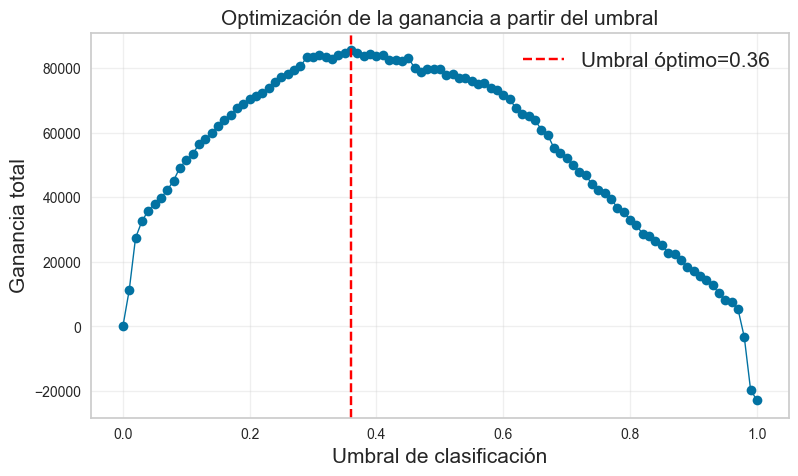

In [29]:
mejor_umbral_ganancia = df_resultados.loc[df_resultados['ganancia'].idxmax()]
print(f"Umbral óptimo: {mejor_umbral_ganancia['umbral']:.4f} con ganancia máxima: {mejor_umbral_ganancia['ganancia']:.4f}")

plt.figure(figsize=(9,5))
plt.plot(df_resultados['umbral'], df_resultados['ganancia'], marker='o', linewidth=1)
plt.axvline(mejor_umbral_ganancia['umbral'], color='red', linestyle='--', label=f"Umbral óptimo={mejor_umbral_ganancia['umbral']:.2f}")
# plt.axvline(0.565, color='red', linestyle='--', label=f"Optimización F1-Score={0.565:.4f}")
plt.xlabel('Umbral de clasificación', fontsize=15)
plt.ylabel('Ganancia total', fontsize=15)
plt.title('Optimización de la ganancia a partir del umbral', fontsize=15)
plt.grid(alpha=0.3)
plt.legend(fontsize=15)
plt.show()

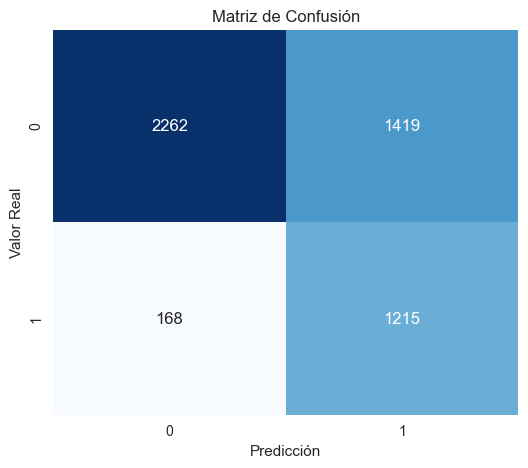


Reporte de métricas por categoría:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      3681
           1       0.46      0.88      0.60      1383

    accuracy                           0.69      5064
   macro avg       0.70      0.75      0.67      5064
weighted avg       0.80      0.69      0.70      5064



In [31]:
# Calcular la matriz de confusión
umbral_optimo_ganancia=mejor_umbral_ganancia['umbral']

y_pred = (y_prob >= umbral_optimo_ganancia).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Graficar
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

print("\nReporte de métricas por categoría:")
print(classification_report(y_test, y_pred))

In [35]:
# Obtención de montos totales por método de optimización 
df_evaluación_montos=pd.DataFrame(
    {
        'Monto':x_test['Monto']**2,
        'Fraude':y_test,
        'Pred_Fraude_F1':(y_prob >= umbral_optimo).astype(int),
        'Pred_Fraude_Ganancia':(y_prob >= umbral_optimo_ganancia).astype(int)
    }
)


print(
    pd.crosstab(
        df_evaluación_montos['Fraude'],
        df_evaluación_montos['Pred_Fraude_F1'],
        values=df_evaluación_montos['Monto'],
        aggfunc='sum'
    ).round(0)
)


print(
    pd.crosstab(
        df_evaluación_montos['Fraude'],
        df_evaluación_montos['Pred_Fraude_Ganancia'],
        values=df_evaluación_montos['Monto'],
        aggfunc='sum'
    ).round(0)
)

ganancia=452319*0.25
perdida_por_fraude=27621

print("ROI", np.round((ganancia-perdida_por_fraude)/perdida_por_fraude, 2))

print("\n Pérdida total:", df_evaluación_montos[df_evaluación_montos['Fraude']==1]['Monto'].sum())


Pred_Fraude_F1         0         1
Fraude                            
0               554856.0   90225.0
1                63418.0  120657.0
Pred_Fraude_Ganancia         0         1
Fraude                                  
0                     452319.0  192762.0
1                      27621.0  156454.0

 Pérdida total: 184075.03


In [50]:
# Cálculo de rentabilidad con el umbral que optimiza la ganancia en la data de evaluación
ganancia=554856*0.25 # Caso pred fraude=0 y fraude=0
perdida_por_fraude=63418 # Caso pred fraude=0 y fraude=1

print("ROI optimización F1-score\n", np.round((ganancia-perdida_por_fraude)/perdida_por_fraude, 1))

ganancia=452319*0.25 # Caso pred fraude=0 y fraude=0
perdida_por_fraude=27621 # Caso pred fraude=0 y fraude=1

print("ROI optimización Ganancia\n", np.round((ganancia-perdida_por_fraude)/perdida_por_fraude, 1))


ROI optimización F1-score
 1.2
ROI optimización Ganancia
 3.1


**Por cada unidad perdida, se obtienen 3.1 adicionales netas de ganancia con el umbral de 0,36. Optimizar la función de ganancia nos hace más rentables, por lo que esta es la metodología sugerida para hacer este un proceso rentable.**

# Se exporta el modelo obtenido

In [ ]:
# Ruta de almacenamiento
model_path=r"..\models\modelo_fraude.joblib"

# Guardar
joblib.dump(best_model, model_path)